In [1]:
import numpy as np
import zarrPlotFunctions as zplt
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.dates import DateFormatter
import xarray as xr
import zarr
import s3fs
import boto3
import numcodecs as ncd
import struct

### Amazon Access Info

In [2]:
REGION = 'us-west-1'
BUCKET = 'hrrrzarr'
DAY = '20200906'

levelVar = '/surface/GUST/surface/GUST/'


s3 = boto3.resource(
    service_name='s3',
    region_name=REGION,
    )

In [3]:
root = '/uufs/chpc.utah.edu/common/home/'
metadata = root+'horel-group7/Pando/hrrr/HRRR_latlon.h5'
x = xr.open_dataset(metadata)
lat = x.latitude.data
lon = x.longitude.data

### Plot 9/7 Labor Day Downslope Windstorm

In [4]:
ptLat = 44.9408
ptLon = -122.4008

x, y = zplt.findChunk(ptLat,ptLon)

chunkID = '0.{}.{}'.format(x,y)

newLats, newLons = zplt.getLatLons(x,y)

i, j = zplt.nearestGridPoint(ptLat,ptLon,newLats,newLons)

In [231]:
# Set up dates
dates2 = []
DAY = []

# Set up hourly time stamps
start = datetime(2020, 9, 5, 12, 0)
end = datetime(2020, 9, 9, 12, 0)
#end = start + timedelta(hours=12)

for times in zplt.perdelta(start, end, timedelta(hours=1)):
    #DAY.append(datetime.strftime(times, '%Y%m%d'))
    #dates2.append(datetime.strftime(times, '%Y%m%d_%Hz'))
    dates2.append(datetime.strftime(times, '%-m/%-d %Hz'))

In [14]:
%%time 

tempFilePath = '/uufs/chpc.utah.edu/common/home/horel-group4/tmccorkle/hrrr_conus/fcst_chunks/'

for hr in range(0,12):
 
    fileName = dates[hr]+'_fcst.zarr'
    fileKey = 'sfc/'+DAY[hr]+'/'+fileName+levelVar+chunkID
    filePath = tempFilePath+dates[hr]+'_chunk'
    s3.meta.client.download_file(BUCKET, fileKey, filePath)
    
    '''
    chunkPath = tempFilePath+dates[hr]+'_chunk'
    # Decompress the chunk you want
    buf = ncd.blosc.decompress(open(chunkPath, 'rb').read())

    chunk = np.frombuffer(buf, dtype='<f2')

    '''

CPU times: user 91.2 ms, sys: 22.3 ms, total: 113 ms
Wall time: 2.14 s


### Decompress Data

In [24]:
tempFilePath = '/uufs/chpc.utah.edu/common/home/horel-group4/tmccorkle/hrrr_conus/fcst_chunks/'
data = np.zeros((96,126))
data[:] = np.nan


for hr in range(0,96):
    chunkPath = tempFilePath+dates[hr]+'_chunk'
    buf = ncd.blosc.decompress(open(chunkPath, 'rb').read())

    chunk = np.frombuffer(buf, dtype='<f2')

    n = int(len(chunk)/22500)
    
    hrrrVar = np.reshape(chunk,((n,150,150)))
    data[hr,hr:hr+n] = hrrrVar[:,i,j]


### Calculate Statistics

In [56]:
stats = np.zeros((4,61))
for i in range(35,96):
    a = np.nanmax(data[:,i])
    b = np.nanmin(data[:,i])
    j = i-35
    stats[0,j] = a
    stats[1,j] = b
    
    stats[2,j] = np.abs(a-b)
    
    stats[3,j] = np.nanmean(data[:,i])
    
non_nans = (~np.isnan(data)).sum(0)

In [258]:
# Station Data

hsfo3 = [3.13,2.68,2.68,2.68,2.23,2.23,1.34,2.23,1.34,1.79,1.34,0.9,
         1.34,1.34,0.9,0.9,1.34,2.23,1.79,3.13,3.13,2.23,4.02,
         6.26,8.49,8.49,9.84,12.96,15.64,15.64,10.73,11.17,11.62,
         12.52,16.54,15.64,14.31,16.54,11.62,14.75,10.73,29.5,
         16.09,13.41,12.52,11.62,12.52,10.73,9.84,9.84,11.17,
         9.84,10.28,10.73,10.28,7.6,10.28,12.07,13.41,10.28,12.5]

In [78]:
# Set up dates
dates = []

# Set up hourly time stamps
start = datetime(2020, 9, 7, 0, 0)
end = start + timedelta(hours=61)

for times in zplt.perdelta(start, end, timedelta(hours=1)):
    dates.append(datetime.strftime(times, '%-H:00\n%-m/%-d/%y'))

### Plots

In [247]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

plotData = data[:,35:96]

modelRuns = np.arange(24,79,6)

evenly_spaced_interval = np.linspace(0, 1, len(modelRuns))
colors = [plt.cm.plasma_r(x) for x in evenly_spaced_interval]

for i, color in enumerate(colors):
    idx = modelRuns[i]
    plt.plot(dates,plotData[idx,:],linewidth=6,color=color,label=dates2[modelRuns[i]])
    
plt.ylabel('Gust (m/s)\n ',fontsize=20)
plt.xlabel('Valid Time (UTC)',fontsize=20)
plt.yticks(ticks = [0,5,10,15,20,25,30,35,40],fontsize=16)
plt.ylim([0,40])
plt.xticks(ticks = [6,18,30,42,54],fontsize=16)

plt.legend(ncol=2,fontsize=16)


#plt.savefig(root+'u1014509/public_html/phd/zarr/timeseriesInit6Hr.pdf')

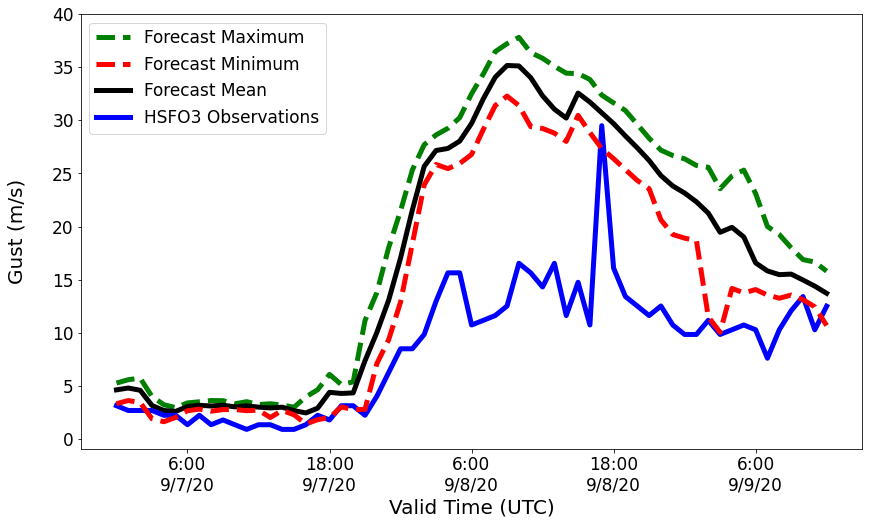

In [270]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

plt.plot(dates,stats[0,:],'--',color='green',linewidth=5,label='Forecast Maximum')
plt.plot(dates,stats[1,:],'--',color='red',linewidth=5,label='Forecast Minimum',zorder=98)
plt.plot(dates,stats[3,:],color='black',linewidth=5,label='Forecast Mean')
plt.plot(dates,hsfo3,color='Blue',linewidth=5,label='HSFO3 Observations',zorder=97)

    
    
plt.ylabel('Gust (m/s)\n ',fontsize=20)
plt.xlabel('Valid Time (UTC)',fontsize=20)
plt.yticks(ticks = [0,5,10,15,20,25,30,35,40],fontsize=17)
plt.xticks(ticks = [6,18,30,42,54],fontsize=17)
plt.legend(fontsize=17)
plt.savefig(root+'u1014509/public_html/phd/zarr/20200907_hrrrHorseCreek_spread_HSOF3.pdf')